# ПРОЕКТ: РАЗМЕТКА ДОКУМЕНТА

#### Intro

Входящие данные: файл InDesign со стандартной стилевой разметкой

Исходящие данные: файл InDesign с расширенной разметкой 


#### Краткий план

Файл разбивается на абзацы, каждый абзац парсится на предмет всех его свойств (таких как стиль, кегль, гарнитура etc.), из которых формируются признаки для модели машинного обучения.

Далее размечается целевой признак (вручную) по классам.  
Большинство классов будут соответствовать стилю абзаца, добавятся лишь начала/концы вставочных элементов:
* преамбул;
* примеров;
* тематических вставок etc.

Далее проведем EDA полученного датасета, займемся генерацией новых признаков и т. д.

После получения готового к машинному обучению набора данных обучим несколько моделей, чтобы выявить лучшую.

Метрика качества (предварительно) - F1.

По итогу выбора лучшей модели прогоним ее на тестовом файле, из которого формируется датасет аналогичным образом.


## Подготовка к работе

Импортируем необходимвые библиотеки, напишем функции для обработки документов и датасетов

#### Библиотеки и параметры

In [2]:
# improts
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import win32com.client

from catboost import CatBoostClassifier, Pool, cv
from category_encoders import MEstimateEncoder
from lightgbm import LGBMClassifier
import optuna
from optuna.samplers import TPESampler
import re
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score, 
    recall_score, 
    precision_score, 
    accuracy_score
    )
from sklearn.preprocessing import (
    OneHotEncoder, 
    StandardScaler, 
    OrdinalEncoder,
    LabelEncoder
    )
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
import torch
import transformers
from tqdm import notebook




#Random state
RS = 45364

#Parameters
app = win32com.client.Dispatch('InDesign.Application.2023')
plt.rcParams["figure.figsize"] = (12, 8)



#### Функции для обработки документов и датасетов

In [3]:
my_doc = app.ActiveDocument


def get_main_story():
    '''
    Return max story in document
    '''

    story_lens = []

    for i in range(1, my_doc.Stories.Count):
        story_lens.append(my_doc.Stories.Item(i).Paragraphs.Count)


    print('Max story length:', max(story_lens), '\nStories:', len(story_lens), '\nMax story index:', story_lens.index(max(story_lens)))

    main_story = my_doc.Stories[story_lens.index(max(story_lens))]

    print('Paragraphs in max story:', (main_story.Paragraphs.Count))

    return main_story


In [4]:
def add_styles():
    # Добавляет лишние стили. Сделать проверку на наличие
    try:
        eqn_end = my_doc.paragraphStyleGroups.item('основной набор').paragraphStyleGroups.item('Пример с плашкой').paragraphStyles.Add()
        eqn_end.basedOn = my_doc.paragraphStyleGroups.item('основной набор').paragraphStyleGroups.item('Пример с плашкой').paragraphStyles.item("Пример с плашкой_Конец")
        eqn_end.Name = "Пример формула конец"
        eqn_end.firstLineIndent = 0
        eqn_end.spaceBefore = 4
        eqn_end.Justification = 1667591796 # 'CENTER_ALIGN'
        eqn_end.ruleBelow = True
        eqn_end.ruleBelowLineWeight = 0.5
        eqn_end.ruleBelowOffset = 4
        #print(eqn_end.Name)
    
    except:
        eqn_end = my_doc.paragraphStyleGroups.item('основной набор').paragraphStyleGroups.item('Пример с плашкой').paragraphStyles.item('Пример формула конец')

        print('Style', eqn_end.Name, ' is on!!!!')

    try:
        pic_end = my_doc.paragraphStyleGroups.item('основной набор').paragraphStyleGroups.item('Пример с плашкой').paragraphStyles.Add()
        pic_end.basedOn = my_doc.paragraphStyleGroups.item('основной набор').paragraphStyleGroups.item('Рисунок').paragraphStyles.item("Подрисуночная подпись")
        pic_end.Name = "Пример рисунок конец"
        pic_end.ruleBelow = True
        pic_end.ruleBelowLineWeight = 0.5
        pic_end.ruleBelowOffset = 4
        #print(pic_end.Name)
    
    except:
        pic_end = my_doc.paragraphStyleGroups.item('основной набор').paragraphStyleGroups.item('Пример с плашкой').paragraphStyles.item('Пример рисунок конец')
        print('Style', pic_end.Name, ' is on!!!!')

    try:
        eqn_end_sans = my_doc.paragraphStyleGroups.item('основной набор').paragraphStyleGroups.item('Пример с плашкой рубленый').paragraphStyles.Add()
        eqn_end_sans.basedOn = my_doc.paragraphStyleGroups.item('основной набор').paragraphStyleGroups.item('Пример с плашкой рубленый').paragraphStyles.item("Пример с плашкой_Конец")
        eqn_end_sans.Name = "Пример Р формула конец"
        eqn_end_sans.firstLineIndent = 0
        eqn_end_sans.spaceBefore = 4
        eqn_end_sans.Justification = 1667591796 # 'CENTER_ALIGN'
        eqn_end_sans.ruleBelow = True
        eqn_end_sans.ruleBelowLineWeight = 0.5
        eqn_end_sans.ruleBelowOffset = 4
        #print(eqn_end_sans.name)
    
    except:
        eqn_end_sans = my_doc.paragraphStyleGroups.item('основной набор').paragraphStyleGroups.item('Пример с плашкой рубленый').paragraphStyles.item('Пример Р формула конец')
        print('Style', eqn_end_sans.Name, ' is on!!!!')
    
    try:
        pic_end_sans = my_doc.paragraphStyleGroups.item('основной набор').paragraphStyleGroups.item('Пример с плашкой рубленый').paragraphStyles.Add()
        pic_end_sans.basedOn = my_doc.paragraphStyleGroups.item('основной набор').paragraphStyleGroups.item('Рисунок').paragraphStyles.item("Подрисуночная подпись")
        pic_end_sans.Name = "Пример Р рисунок конец"
        pic_end_sans.ruleBelow = True
        pic_end_sans.ruleBelowLineWeight = 0.5
        pic_end_sans.ruleBelowOffset = 4
        #print(pic_end_sans.name)
    
    except:
        pic_end_sans = my_doc.paragraphStyleGroups.item('основной набор').paragraphStyleGroups.item('Пример с плашкой рубленый').paragraphStyles.item('Пример Р рисунок конец')
        print('Style', pic_end_sans.Name, ' is on!!!!')

In [5]:
def get_paragraphs(main_story):
    '''
    in: story
    out: list of paragraphs in story
    '''
    pre_data = []

    for i in range(1, main_story.Paragraphs.Count+1):
        pre_data.append(main_story.paragraphs.Item(i))
    return pre_data


In [6]:
def features_engineering(pre_data):
    """
    Make features form paragraphs state,
    i.e. style, font, font size etc.
    """

    data = pd.DataFrame(pre_data, columns=['paragraph'])

    data['content'] = data['paragraph'].apply(lambda x: x.contents.strip()).str.replace('\ufeff', '')

    # data['content'] = full_data['content'].str.replace('\ufeff', '')

    # Features

    data['align'] = data['paragraph'].apply(lambda x: x.Justification).replace(map_replace_align)

    data['style_group'] = data['paragraph'].apply(lambda x: x.appliedParagraphStyle.Parent.name)

    data['style'] = data['paragraph'].apply(lambda x: x.appliedParagraphStyle.name)
    data['prev_style'] = data['style'].shift(1)
    data['next_style'] = data['style'].shift(-1)

    data['font_name'] = data['paragraph'].apply(lambda x: x.appliedFont.name.split('\t')[0])
    data['font_size'] = data['paragraph'].apply(lambda x: x.pointSize)

    data['space_before'] = data['paragraph'].apply(lambda x: x.spaceBefore)
    data['space_after'] = data['paragraph'].apply(lambda x: x.spaceAfter)
    
    data['left_ident'] = data['paragraph'].apply(lambda x: x.leftIndent)
    data['right_ident'] = data['paragraph'].apply(lambda x: x.rightIndent)
    data['first_line_ident'] = data['paragraph'].apply(lambda x: x.firstLineIndent)

    data['is_pict_on'] = (data['content'].str.contains('Рис\.|рис\.|Рисун', regex=True)) & (data['style'] != 'Подрисуночная подпись')
    data['is_table_on'] = data['content'].str.contains('Табл\.|табл\.', regex=True) & (data['style'] != 'Табл. номер')
    data['is_eqn_on'] = data['content'].str.contains('\(\d+\.\d+\)', regex=True) & (data['style'] != 'Формула однострочная') & (data['style'] != 'Формула 5 мм') & (data['style'] != 'Формула высокая') & (data['style'] != 'Формула ПРИМЕР')

    data['length'] = data['content'].apply(lambda x: len(x))
    data['words_count'] = data['content'].apply(lambda x: len(x.split()))
    
    data['start_with_digits'] = data['content'].apply(
        lambda x: (len(re.search(r'^(\d+\.)((\d+\.)+)', x)[0].split('.')[:-1])) 
        if re.search(r'^(\d+\.)((\d+\.)+)', x) 
        else 0
        )

    # Target 

    data['group+style'] = data['style_group'] + ' &&& ' + data['style']
    
    return data


In [7]:
#import indesign_2021 as indd

map_replace_align = {
    1667591796: 'Center',
    1818584692: 'Left',
    1919379572: 'Right',
    1818915700: 'Justifed'
}

# map_replace_align

#### Формирование датафрейма и добавление новых признаков

In [7]:
# data = 2503
# data2 = 43507
# data3 =  3252
main_story = get_main_story()

add_styles()

pre_data = get_paragraphs(main_story)

Max story length: 2857 
Stories: 108 
Max story index: 4
Paragraphs in max story: 2857
Style Пример формула конец  is on!!!!
Style Пример рисунок конец  is on!!!!
Style Пример Р формула конец  is on!!!!
Style Пример Р рисунок конец  is on!!!!


In [18]:

data = features_engineering(pre_data)

data

,paragraph,content,align,style_group,style,prev_style,next_style,font_name,font_size,space_before,...,left_ident,right_ident,first_line_ident,is_pict_on,is_table_on,is_eqn_on,length,words_count,start_with_digits,group+style
0,<COMObject Item>,Предисловие,Center,навигация по книге,Приложения к книге,NaN,Основной текст,Myriad Pro,18.0,10.0,...,0.0,0.0,0.0,False,False,False,11,1,0,навигация по книге &&& Приложения к книге
1,<COMObject Item>,Предлагаемый курс возник как итог многолетней ...,Justifed,основной набор,Основной текст,Приложения к книге,Основной текст,CharterITC,10.5,0.0,...,0.0,0.0,5.0,False,False,False,997,114,0,основной набор &&& Основной текст
2,<COMObject Item>,Данный курс адресован в первую очередь студент...,Justifed,основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,0.0,...,0.0,0.0,5.0,False,False,False,738,88,0,основной набор &&& Основной текст
3,<COMObject Item>,"Преамбула, с которой начинается каждая тема, в...",Justifed,основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,0.0,...,0.0,0.0,5.0,False,False,False,562,76,0,основной набор &&& Основной текст
4,<COMObject Item>,"Излагая теорию, авторы зачастую отказываются о...",Justifed,основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,0.0,...,0.0,0.0,5.0,False,False,False,829,105,0,основной набор &&& Основной текст
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6796,<COMObject Item>,"28.\tСухотин, А. М. Высшая математика. Альтерн...",Justifed,основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,0.0,...,0.0,0.0,5.0,False,False,False,209,33,0,основной набор &&& Основной текст
6797,<COMObject Item>,"29.\tХорошилова, Е. В. Высшая математика. Лекц...",Justifed,основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,0.0,...,0.0,0.0,5.0,False,False,False,176,30,0,основной набор &&& Основной текст
6798,<COMObject Item>,"30.\tШипачев, В. С. Высшая математика : учебно...",Justifed,основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,0.0,...,0.0,0.0,5.0,False,False,False,179,33,0,основной набор &&& Основной текст
6799,<COMObject Item>,"31.\tШипачев, В. С. Высшая математика. Полный ...",Justifed,основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,0.0,...,0.0,0.0,5.0,False,False,False,229,45,0,основной набор &&& Основной текст


## Анализ данных

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6801 entries, 0 to 6800
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   paragraph          6801 non-null   object 
 1   content            6801 non-null   object 
 2   align              6801 non-null   object 
 3   style_group        6801 non-null   object 
 4   style              6801 non-null   object 
 5   prev_style         6800 non-null   object 
 6   next_style         6800 non-null   object 
 7   font_name          6801 non-null   object 
 8   font_size          6801 non-null   float64
 9   space_before       6801 non-null   float64
 10  space_after        6801 non-null   float64
 11  left_ident         6801 non-null   float64
 12  right_ident        6801 non-null   float64
 13  first_line_ident   6801 non-null   float64
 14  is_pict_on         6801 non-null   bool   
 15  is_table_on        6801 non-null   bool   
 16  is_eqn_on          6801 

In [20]:
data.describe()

,font_size,space_before,space_after,left_ident,right_ident,first_line_ident,length,words_count,start_with_digits
count,6801.000000,6801.000000,6801.000000,6801.000000,6801.000000,6801.000000,6801.000000,6801.000000,6801.000000
mean,9.897368,1.121306,1.445670,1.098074,0.641082,3.431113,81.192472,12.201441,0.015292
std,1.076750,2.018478,2.329468,4.963626,1.671776,2.320306,137.934015,19.104019,0.174225
min,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2.000000,0.000000
50%,10.000000,0.000000,0.000000,0.000000,0.000000,5.000000,37.000000,6.000000,0.000000
75%,10.500000,2.000000,3.000000,0.000000,0.000000,5.000000,99.000000,14.000000,0.000000
max,20.000000,24.000000,34.000000,50.000000,5.000000,5.000000,2188.000000,283.000000,2.000000


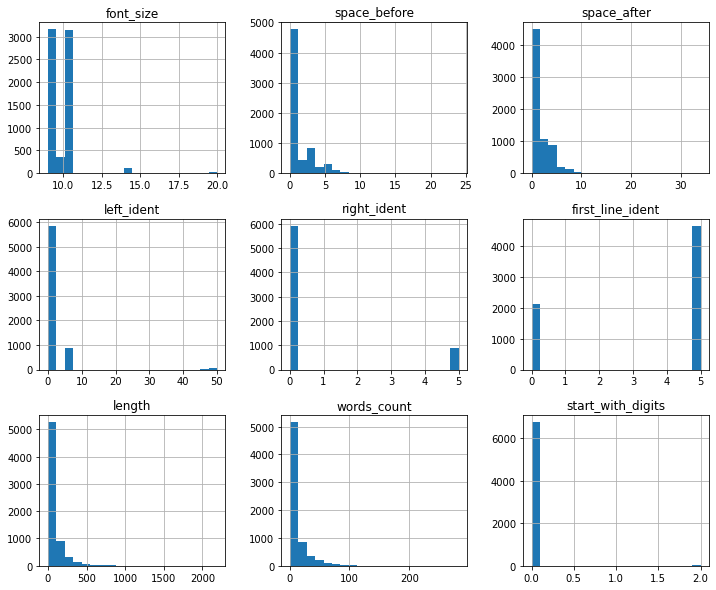

In [21]:
data.hist(figsize=(12, 10), bins=20);

Из гистограмм видим:
1. Размер кегля преобладает 9 и 10,5;  


2. Длина абазаца в символах в большинстве случаев - около 100, впятеро меньше абзацев длиной 200-300 символом.  
Также есть огромные абзацы длиной от 500 до 2188 символов, но их количество крайне мало;  


3. Аналогична ситуация со словами - большинство абзацев содержат до 25 слов.

In [22]:
style_pivot = data.pivot_table(
    index=['style_group', 'style'],
    #columns='content',
    values=['words_count', 'length'], 
    aggfunc=['count', 'mean']
    ).reset_index()

style_pivot.columns = ['_'.join(col) for col in style_pivot.columns]

style_pivot

,style_group_,style_,count_length,count_words_count,mean_length,mean_words_count
0,Преамбулы к главе,Преамбула к главе внутри,238,238,79.865546,10.579832
1,Преамбулы к главе,Преамбула к главе конец,20,20,45.900000,5.800000
2,Преамбулы к главе,Преамбула к главе начало,20,20,1079.700000,146.700000
3,Пример с плашкой,Пример рисунок конец,14,14,8.285714,2.000000
4,Пример с плашкой,Пример с плашкой_ Внутри,228,228,88.307018,13.951754
5,Пример с плашкой,Пример с плашкой_ Заголовок,90,90,9.966667,1.988889
6,Пример с плашкой,Пример с плашкой_Конец,42,42,156.476190,24.023810
7,Пример с плашкой,Пример формула конец,34,34,1.205882,1.029412
8,Пример с плашкой рубленый,Пример Р рисунок конец,13,13,8.307692,2.000000
9,Пример с плашкой рубленый,Пример Р формула конец,33,33,1.181818,1.030303


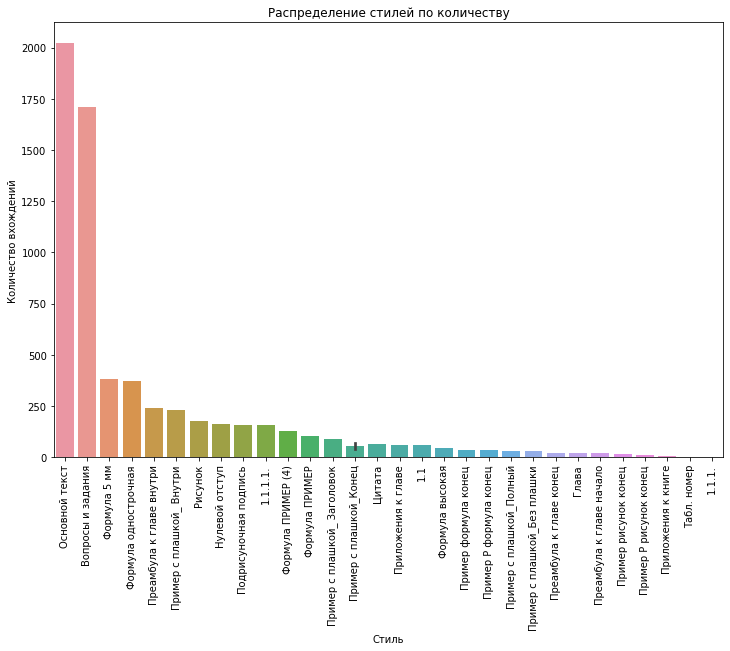

In [23]:
sns.barplot(
    x=style_pivot.sort_values(by='count_length', ascending=False)['style_'],
    y=style_pivot.sort_values(by='count_length', ascending=False)['count_length']
    )

plt.title('Распределение стилей по количеству')
plt.xlabel('Стиль')
plt.ylabel('Количество вхождений')
plt.xticks(rotation=90);


Очевидно, но основной текст - наиболее часто используемый стиль.

Учебник также достаточно сильно насыщен контрольными вопросами и заданиями.

Довольно большое количество рисунков, много формул.  
Вероятно, это книжка по естественно-научной дисциплине :)

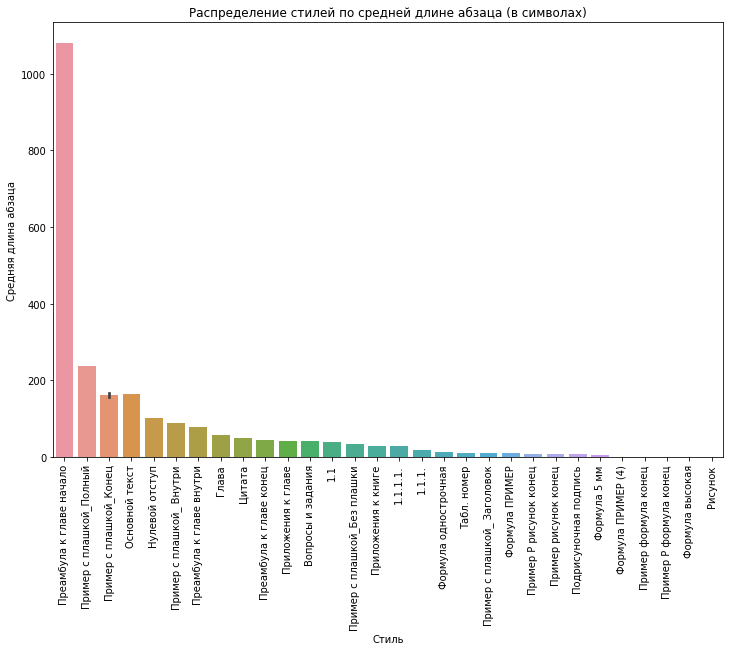

In [24]:
sns.barplot(
    x=style_pivot.sort_values(by='mean_length', ascending=False)['style_'],
    y=style_pivot.sort_values(by='mean_length', ascending=False)['mean_length']
    )

plt.title('Распределение стилей по средней длине абзаца (в символах)')
plt.xlabel('Стиль')
plt.ylabel('Средняя длина абзаца')
plt.xticks(rotation=90);


Странный лидер графика.  
Не видя текста, но зная структуру учебников, вполне можно предположить, что каждая глава содержит объемное вступление в преамбуле.  
Также отмечу довольно большой объем замечаний (стили "Пример с плашкой полный" и "...без плашки").

Основной текст лишь на 4 месте со средней длиной абзаца около 200 символов.  
Возможно, статистика слегка прихрамывает из-за формул (которые считаются за один символ), но общую тенденцию тем не менее отражает

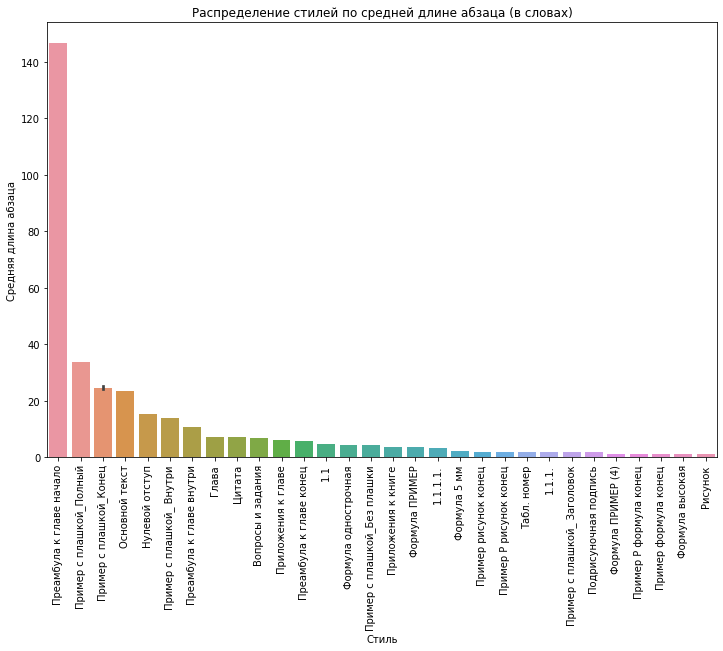

In [25]:
sns.barplot(
    x=style_pivot.sort_values(by='mean_words_count', ascending=False)['style_'],
    y=style_pivot.sort_values(by='mean_words_count', ascending=False)['mean_words_count']
    )

plt.title('Распределение стилей по средней длине абзаца (в словах)')
plt.xlabel('Стиль')
plt.ylabel('Средняя длина абзаца')
plt.xticks(rotation=90);


И практически аналогичная картина при анализе по количеству слов.

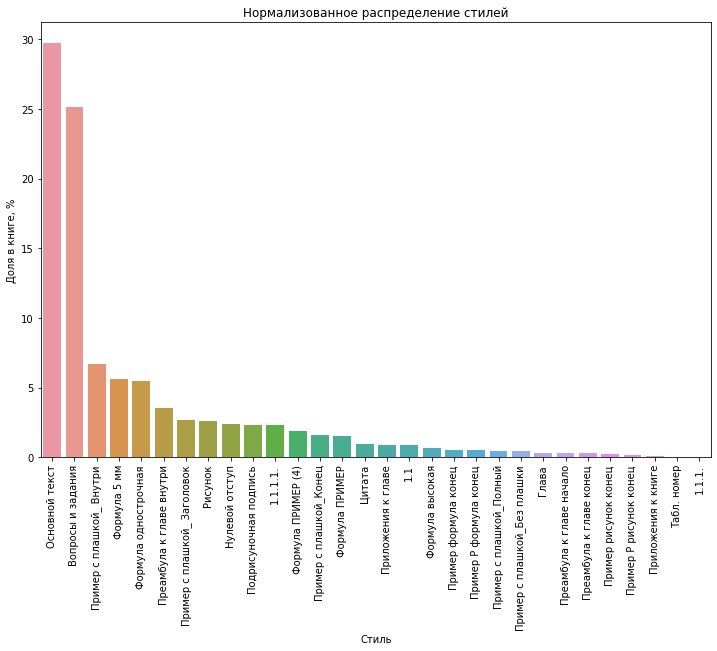

In [26]:
sns.barplot(
    x=data['style'].value_counts(normalize=True).index,
    y=data['style'].value_counts(normalize=True).values*100
    )

plt.title('Нормализованное распределение стилей')
plt.xlabel('Стиль')
plt.ylabel('Доля в книге, %')
plt.xticks(rotation=90);

## Расширение данных

Добавим еще пару книг для увеличения объема данных

In [28]:
# ToDo - функция с загрузкой документов из папки

In [29]:
# Переопределим документ data2 = 43507
my_doc = app.ActiveDocument

# Добавим стили, если их нет
add_styles()

# Определим main_story
main_story2 = get_main_story()

# Разобьем на абзацы и создадим еще один датафрейм
pre_data2 = get_paragraphs(main_story2)
data2 = features_engineering(pre_data2)

data2

Style Пример формула конец  is on!!!!
Style Пример рисунок конец  is on!!!!
Max story length: 5836 
Stories: 1643 
Max story index: 4
Paragraphs in max story: 5836


,paragraph,content,align,style_group,style,prev_style,next_style,font_name,font_size,space_before,...,left_ident,right_ident,first_line_ident,is_pict_on,is_table_on,is_eqn_on,length,words_count,start_with_digits,group+style
0,<COMObject Item>,Предисловие,Center,навигация по книге,Приложения к книге,NaN,Основной текст,Myriad Pro,18.0,10.0,...,0.0,0.0,0.0,False,False,False,11,1,0,навигация по книге &&& Приложения к книге
1,<COMObject Item>,Настоящее пособие написано в соответствии с ак...,Justifed,основной набор,Основной текст,Приложения к книге,Основной текст,CharterITC,10.5,0.0,...,0.0,0.0,5.0,False,False,False,176,19,0,основной набор &&& Основной текст
2,<COMObject Item>,"Известно, что решение задач по математике у ст...",Justifed,основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,0.0,...,0.0,0.0,5.0,False,False,False,261,37,0,основной набор &&& Основной текст
3,<COMObject Item>,При самостоятельном решении задач многие студе...,Justifed,основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,0.0,...,0.0,0.0,5.0,False,False,False,293,40,0,основной набор &&& Основной текст
4,<COMObject Item>,В каждом параграфе приведены краткие теоретиче...,Justifed,основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,0.0,...,0.0,0.0,5.0,False,False,False,528,74,0,основной набор &&& Основной текст
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5831,<COMObject Item>,Глава 16,Center,навигация по книге,1.1.1.1.,Основной текст,Основной текст,CharterITC,10.5,3.0,...,0.0,0.0,0.0,False,False,False,8,2,0,навигация по книге &&& 1.1.1.1.
5832,<COMObject Item>,7. \t1) 2730; 2) (m - 1)(m - 2) ⋅ … ⋅ 6 ⋅ 5. 8...,Justifed,основной набор,Основной текст,1.1.1.1.,Нулевой отступ,CharterITC,10.5,0.0,...,0.0,0.0,5.0,False,False,False,214,64,0,основной набор &&& Основной текст
5833,<COMObject Item>,3) ￼. 17. 1) ￼; 2) ￼; 3) ￼. 18. 1) n ≤ 4;,Justifed,основной набор,Нулевой отступ,Основной текст,Нулевой отступ,CharterITC,10.5,0.0,...,0.0,0.0,0.0,False,False,False,41,14,0,основной набор &&& Нулевой отступ
5834,<COMObject Item>,2) n ≥ 6. 19. 3 628 800. 20. 12!. 21. 120. 22....,Justifed,основной набор,Нулевой отступ,Нулевой отступ,Основной текст,CharterITC,10.5,0.0,...,0.0,0.0,0.0,False,False,False,552,125,0,основной набор &&& Нулевой отступ


Тоже мельком посмотрим на статистику по этой книге

In [30]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5836 entries, 0 to 5835
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   paragraph          5836 non-null   object 
 1   content            5836 non-null   object 
 2   align              5836 non-null   object 
 3   style_group        5836 non-null   object 
 4   style              5836 non-null   object 
 5   prev_style         5835 non-null   object 
 6   next_style         5835 non-null   object 
 7   font_name          5836 non-null   object 
 8   font_size          5836 non-null   float64
 9   space_before       5836 non-null   float64
 10  space_after        5836 non-null   float64
 11  left_ident         5836 non-null   float64
 12  right_ident        5836 non-null   float64
 13  first_line_ident   5836 non-null   float64
 14  is_pict_on         5836 non-null   bool   
 15  is_table_on        5836 non-null   bool   
 16  is_eqn_on          5836 

In [31]:
data2.describe()

,font_size,space_before,space_after,left_ident,right_ident,first_line_ident,length,words_count,start_with_digits
count,5836.000000,5836.000000,5836.000000,5836.000000,5836.000000,5836.000000,5836.000000,5836.000000,5836.000000
mean,10.069825,1.089325,1.536498,0.000857,0.000857,3.608636,69.387252,14.097327,0.045922
std,1.215530,2.203648,2.491065,0.065450,0.065450,2.240934,132.482644,35.480911,0.299584
min,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000,4.000000,0.000000
50%,10.500000,0.000000,0.000000,0.000000,0.000000,5.000000,42.000000,9.000000,0.000000
75%,10.500000,2.000000,3.000000,0.000000,0.000000,5.000000,84.000000,17.000000,0.000000
max,35.000000,30.000000,34.000000,5.000000,5.000000,5.000000,5593.000000,1734.000000,2.000000


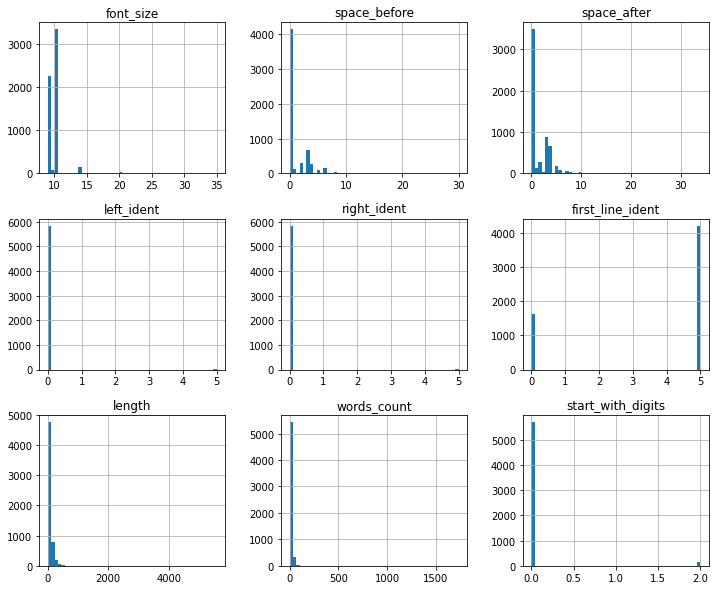

In [32]:
data2.hist(figsize=(12, 10), bins=50);

Из гистограмм видим:
1. Размер кегля преобладает 9 и 10,5;  


2. Снова преобладают короткие абзацы.  
Также есть огромные абзацы длиной более 1000 символов, но их количество крайне мало;  


3. Аналогична ситуация со словами - большинство абзацев содержат до 25 слов.

In [33]:
style_pivot = data2.pivot_table(
    index=['style_group', 'style'],
    #columns='content',
    values=['words_count', 'length'], 
    aggfunc=['count', 'mean']
    ).reset_index()

style_pivot.columns = ['_'.join(col) for col in style_pivot.columns]

style_pivot

,style_group_,style_,count_length,count_words_count,mean_length,mean_words_count
0,43507_1_978-5-534-18418-1.indd,[основной абзац],8,8,0.000000,0.000000
1,Петиты,Петит Внутри,696,696,76.899425,14.875000
2,Петиты,Петит Начало,347,347,102.755043,19.665706
3,Петиты,Петит Окончание,226,226,83.269912,16.659292
4,Петиты,Петит Полный,37,37,184.486486,37.162162
5,Пример с плашкой,Пример с плашкой_ Внутри,1,1,62.000000,7.000000
6,Рисунок,Подрисуночная подпись,94,94,9.404255,2.287234
7,Рисунок,Рисунок,88,88,1.000000,1.000000
8,Таблица,Табл. номер,6,6,11.000000,2.000000
9,Формулы,Формула 5 мм,120,120,7.658333,2.008333


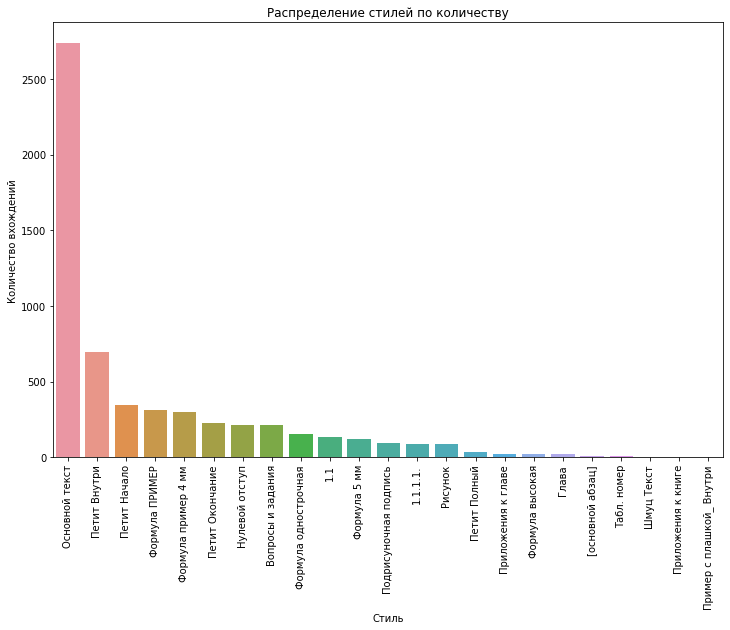

In [34]:
sns.barplot(
    x=style_pivot.sort_values(by='count_length', ascending=False)['style_'],
    y=style_pivot.sort_values(by='count_length', ascending=False)['count_length']
    )

plt.title('Распределение стилей по количеству')
plt.xlabel('Стиль')
plt.ylabel('Количество вхождений')
plt.xticks(rotation=90);


Аналогично предыдущей книге, основной текст - наиболее часто используемый стиль.

Но в отличие от предыдущего, этот учебник имеет гораздо меньше контрольных вопросов.  
Зато куда как более щедр на примеры (стиль "Петит").

Снова большое количество формул, но рисунков уже меньше (~100).  
Опять можно сделать вывод, что это книжка по естественно-научной дисциплине.

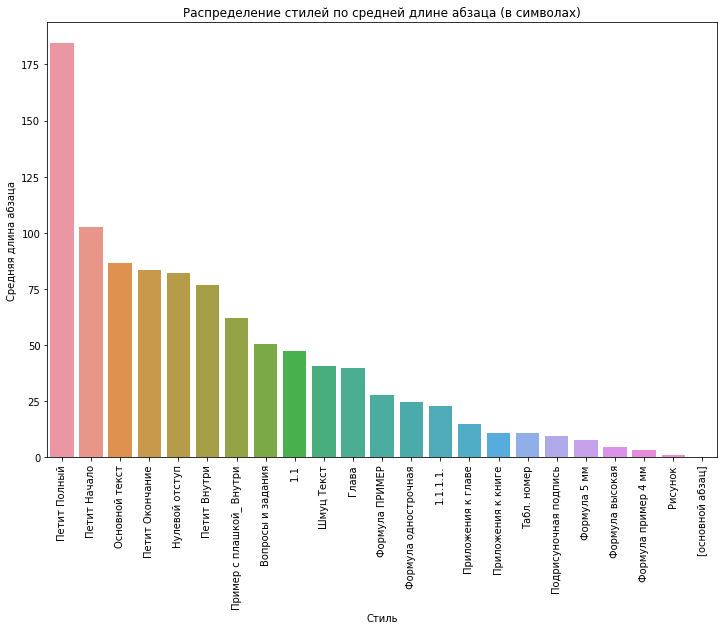

In [35]:
sns.barplot(
    x=style_pivot.sort_values(by='mean_length', ascending=False)['style_'],
    y=style_pivot.sort_values(by='mean_length', ascending=False)['mean_length']
    )

plt.title('Распределение стилей по средней длине абзаца (в символах)')
plt.xlabel('Стиль')
plt.ylabel('Средняя длина абзаца')
plt.xticks(rotation=90);


Самые длинные абзацы - в примерах.
Основной текст лишь имеет абзацы со средней длиной около 85 символов.  
Хотя исходя из названия ("Практические задания по математике"), все становится на свои места:  
текст насущен недлинными условиями задач.


Возможно, статистика слегка прихрамывает из-за формул (которые считаются за один символ), но общую тенденцию тем не менее отражает.

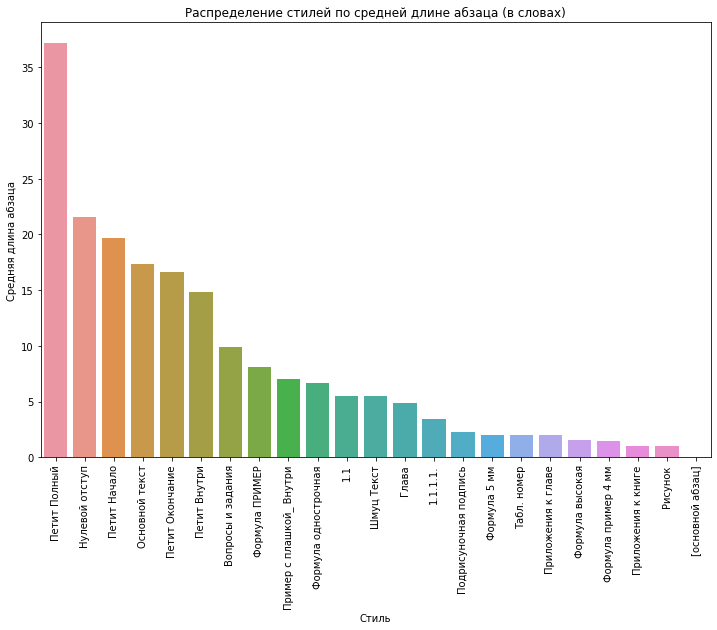

In [36]:
sns.barplot(
    x=style_pivot.sort_values(by='mean_words_count', ascending=False)['style_'],
    y=style_pivot.sort_values(by='mean_words_count', ascending=False)['mean_words_count']
    )

plt.title('Распределение стилей по средней длине абзаца (в словах)')
plt.xlabel('Стиль')
plt.ylabel('Средняя длина абзаца')
plt.xticks(rotation=90);


И практически аналогичная картина при анализе по количеству слов.

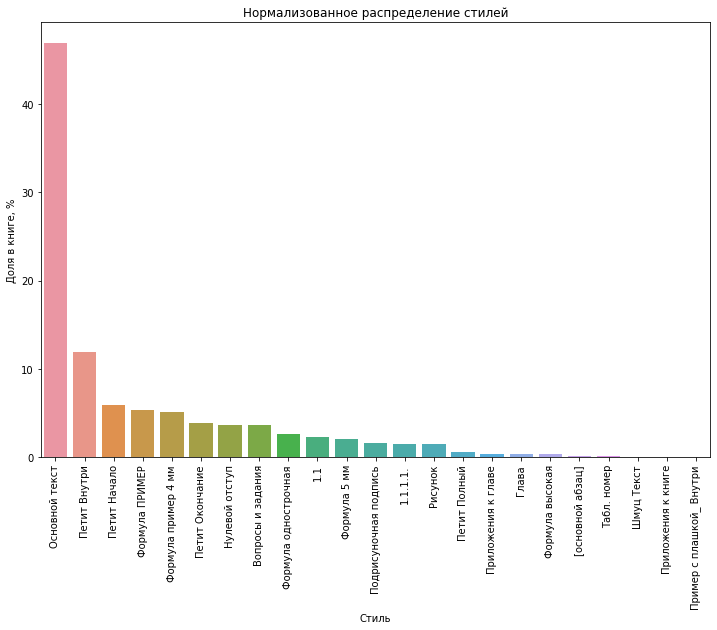

In [37]:
sns.barplot(
    x=data2['style'].value_counts(normalize=True).index,
    y=data2['style'].value_counts(normalize=True).values*100
    )

plt.title('Нормализованное распределение стилей')
plt.xlabel('Стиль')
plt.ylabel('Доля в книге, %')
plt.xticks(rotation=90);

Здесь почти половину абзацев всего текста составляет основной текст.

In [38]:
# Переопределим документ data3 =  3252

my_doc = app.ActiveDocument

# Добавим стили, если их нет
add_styles()

# Определим main_story
main_story3 = get_main_story()

# Разобьем на абзацы и создадим еще один датафрейм
pre_data3 = get_paragraphs(main_story3)
data3 = features_engineering(pre_data3)

data3

Style Пример формула конец  is on!!!!
Style Пример рисунок конец  is on!!!!
Max story length: 2515 
Stories: 766 
Max story index: 4
Paragraphs in max story: 2515


,paragraph,content,align,style_group,style,prev_style,next_style,font_name,font_size,space_before,...,left_ident,right_ident,first_line_ident,is_pict_on,is_table_on,is_eqn_on,length,words_count,start_with_digits,group+style
0,<COMObject Item>,Список сокращений,Center,навигация по книге,Приложения к книге,NaN,Основной текст,Myriad Pro,18.0,10.0,...,0.0,0.0,0.0,False,False,False,17,2,0,навигация по книге &&& Приложения к книге
1,<COMObject Item>,АД — артериальное давление,Justifed,основной набор,Основной текст,Приложения к книге,Основной текст,CharterITC,10.5,0.0,...,0.0,0.0,5.0,False,False,False,26,4,0,основной набор &&& Основной текст
2,<COMObject Item>,АДГ — антидиуретический гормон (вазопрессин),Justifed,основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,0.0,...,0.0,0.0,5.0,False,False,False,44,5,0,основной набор &&& Основной текст
3,<COMObject Item>,АКТГ — адренокортикотропный гормон,Justifed,основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,0.0,...,0.0,0.0,5.0,False,False,False,34,4,0,основной набор &&& Основной текст
4,<COMObject Item>,АТФ — аденозинтрифосфат,Justifed,основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,0.0,...,0.0,0.0,5.0,False,False,False,23,3,0,основной набор &&& Основной текст
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2510,<COMObject Item>,"12.\tВведенский, Н. Е. Избранные сочинения по ...",Justifed,основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,0.0,...,0.0,0.0,5.0,False,False,False,158,29,0,основной набор &&& Основной текст
2511,<COMObject Item>,"13.\tМечников, И. И. Этюды о природе человека ...",Justifed,основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,0.0,...,0.0,0.0,5.0,False,False,False,147,28,0,основной набор &&& Основной текст
2512,<COMObject Item>,"14.\tПавлов, И. П. Лекции о работе главных пищ...",Justifed,основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,0.0,...,0.0,0.0,5.0,False,False,False,146,26,0,основной набор &&& Основной текст
2513,<COMObject Item>,"15.\tСамойлов, А. Ф. О физиологии. Избранные с...",Justifed,основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,0.0,...,0.0,0.0,5.0,False,False,False,142,26,0,основной набор &&& Основной текст


Тоже мельком посмотрим на статистику по этой книге

In [39]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2515 entries, 0 to 2514
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   paragraph          2515 non-null   object 
 1   content            2515 non-null   object 
 2   align              2515 non-null   object 
 3   style_group        2515 non-null   object 
 4   style              2515 non-null   object 
 5   prev_style         2514 non-null   object 
 6   next_style         2514 non-null   object 
 7   font_name          2515 non-null   object 
 8   font_size          2515 non-null   float64
 9   space_before       2515 non-null   float64
 10  space_after        2515 non-null   float64
 11  left_ident         2515 non-null   float64
 12  right_ident        2515 non-null   float64
 13  first_line_ident   2515 non-null   float64
 14  is_pict_on         2515 non-null   bool   
 15  is_table_on        2515 non-null   bool   
 16  is_eqn_on          2515 

In [40]:
data3.describe()

,font_size,space_before,space_after,left_ident,right_ident,first_line_ident,length,words_count,start_with_digits
count,2515.000000,2515.000000,2515.00000,2515.000000,2515.000000,2515.000000,2515.000000,2515.000000,2515.000000
mean,10.398807,0.678529,0.53161,0.005567,0.005567,3.695825,300.035785,38.858847,0.100994
std,1.235657,1.424421,1.74603,0.205263,0.205263,2.195887,317.636277,40.290912,0.510957
min,9.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,0.000000,0.00000,0.000000,0.000000,0.000000,53.000000,7.000000,0.000000
50%,10.500000,0.000000,0.00000,0.000000,0.000000,5.000000,168.000000,24.000000,0.000000
75%,10.500000,0.000000,0.00000,0.000000,0.000000,5.000000,483.000000,61.000000,0.000000
max,35.000000,10.000000,34.00000,9.000000,9.000000,5.000000,1886.000000,256.000000,3.000000


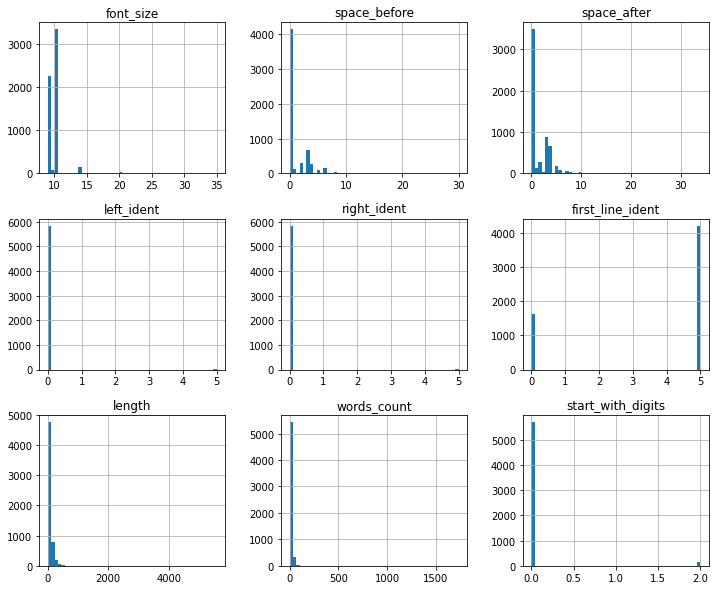

In [41]:
data2.hist(figsize=(12, 10), bins=50);

Из гистограмм видим:
1. Размер кегля преобладает 9 и 10,5;  


2. Снова преобладают короткие абзацы.  
Абзацы относительно прошлых книг доходят до 5000 символов;  


3. Аналогична ситуация со словами - есть абзацы в 1750 слов.

In [42]:
style_pivot = data3.pivot_table(
    index=['style_group', 'style'],
    #columns='content',
    values=['words_count', 'length'], 
    aggfunc=['count', 'mean']
    ).reset_index()

style_pivot.columns = ['_'.join(col) for col in style_pivot.columns]

style_pivot

,style_group_,style_,count_length,count_words_count,mean_length,mean_words_count
0,Преамбулы к главе,Преамбула к главе внутри,56,56,47.428571,6.053571
1,Преамбулы к главе,Преамбула к главе конец,5,5,38.400000,5.000000
2,Преамбулы к главе,Преамбула к главе начало,6,6,49.000000,7.000000
3,Пример с плашкой,Пример с плашкой_Конец,1,1,37.000000,5.000000
4,Рисунок,Легенда,64,64,145.031250,21.890625
5,Рисунок,Подрисуночная подпись,214,214,65.205607,8.677570
6,Рисунок,Рисунок,212,212,1.056604,1.028302
7,Рисунок,Рисунок - текст,1,1,0.000000,0.000000
8,Таблица,Табл. заголовок,12,12,57.916667,6.583333
9,Таблица,Табл. номер,12,12,11.000000,2.000000


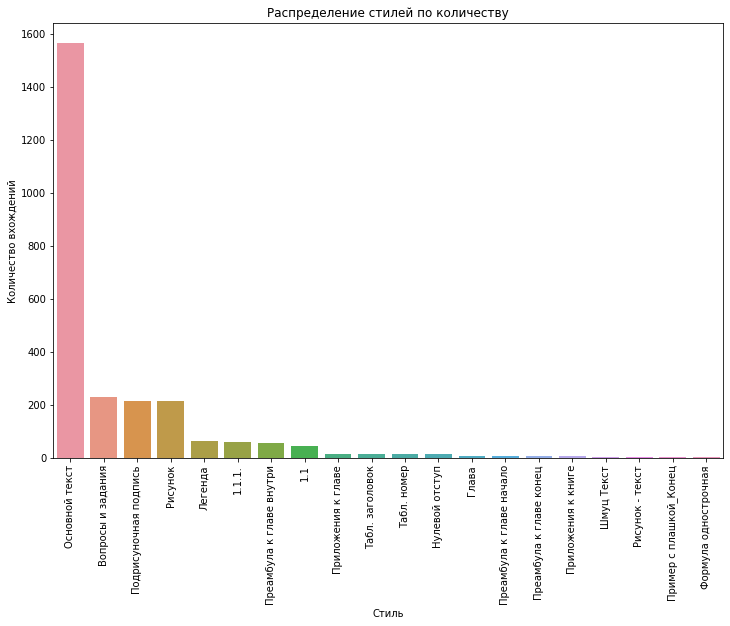

In [43]:
sns.barplot(
    x=style_pivot.sort_values(by='count_length', ascending=False)['style_'],
    y=style_pivot.sort_values(by='count_length', ascending=False)['count_length']
    )

plt.title('Распределение стилей по количеству')
plt.xlabel('Стиль')
plt.ylabel('Количество вхождений')
plt.xticks(rotation=90);


Аналогично предыдущей книге, основной текст - наиболее часто используемый стиль.

Также меньше контрольных вопросов, но изобилует рисунками (около 200 шт.).

Формул совсем нет. В наиболее часто используемых стилях видим практически все заголовки.  
Можно сделать вывод, что книга довольно простая по структуре (основной текст + вопросы + рисунки + заголовки).

Также в конце графика стиль конца примера ненавязчиво намекает, что он где-то ошибочно использован,  
поскольку нет ни начала, ни середины примера. 

Отметим этот факт как возможность генерации дополнительного признака о неправильной разметке.  

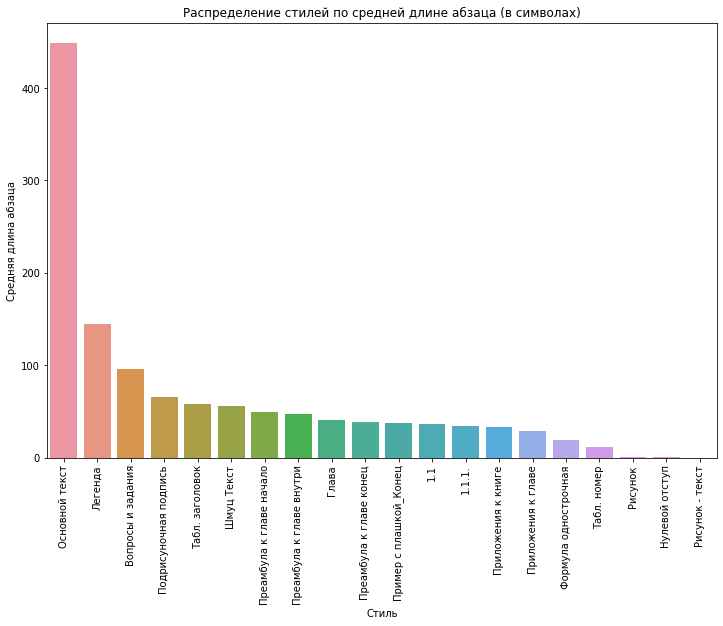

In [44]:
sns.barplot(
    x=style_pivot.sort_values(by='mean_length', ascending=False)['style_'],
    y=style_pivot.sort_values(by='mean_length', ascending=False)['mean_length']
    )

plt.title('Распределение стилей по средней длине абзаца (в символах)')
plt.xlabel('Стиль')
plt.ylabel('Средняя длина абзаца')
plt.xticks(rotation=90);


Самые длинные абзацы - основной текст - около 500 символов в среднем.  
Также заметим обширные легенды к рисункам.

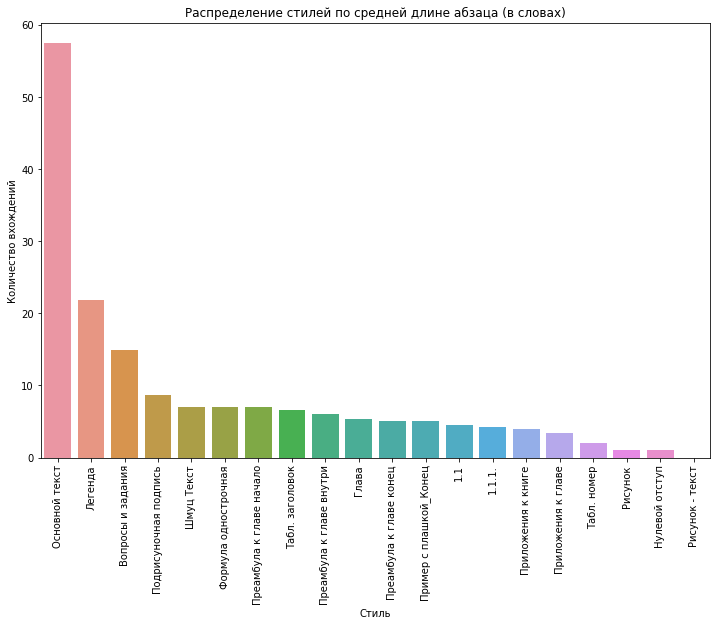

In [45]:
sns.barplot(
    x=style_pivot.sort_values(by='mean_words_count', ascending=False)['style_'],
    y=style_pivot.sort_values(by='mean_words_count', ascending=False)['mean_words_count']
    )

plt.title('Распределение стилей по средней длине абзаца (в словах)')
plt.xlabel('Стиль')
plt.ylabel('Количество вхождений')
plt.xticks(rotation=90);


И практически аналогичная картина при анализе по количеству слов.

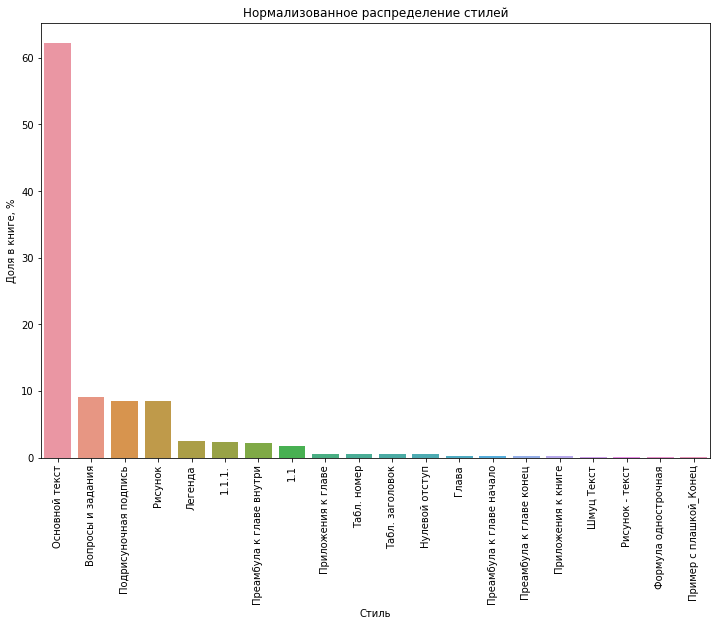

In [46]:
sns.barplot(
    x=data3['style'].value_counts(normalize=True).index,
    y=data3['style'].value_counts(normalize=True).values*100
    )

plt.title('Нормализованное распределение стилей')
plt.xlabel('Стиль')
plt.ylabel('Доля в книге, %')
plt.xticks(rotation=90);

Более 60 % книги - основной текст.  

## Предобработка данных

Объединим данные. Столбец с объектом параграфа сразу удалим - он более не понадобится.

In [47]:

full_data = pd.concat([data, data2, data3])
#full_data.drop('paragraph', axis=1, inplace=True)




full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15152 entries, 0 to 2514
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   paragraph          15152 non-null  object 
 1   content            15152 non-null  object 
 2   align              15152 non-null  object 
 3   style_group        15152 non-null  object 
 4   style              15152 non-null  object 
 5   prev_style         15149 non-null  object 
 6   next_style         15149 non-null  object 
 7   font_name          15152 non-null  object 
 8   font_size          15152 non-null  float64
 9   space_before       15152 non-null  float64
 10  space_after        15152 non-null  float64
 11  left_ident         15152 non-null  float64
 12  right_ident        15152 non-null  float64
 13  first_line_ident   15152 non-null  float64
 14  is_pict_on         15152 non-null  bool   
 15  is_table_on        15152 non-null  bool   
 16  is_eqn_on          1515

In [48]:
full_data.fillna('None', inplace=True)

Проверим на пустые строки

In [49]:
full_data.query('content == ""')

,paragraph,content,align,style_group,style,prev_style,next_style,font_name,font_size,space_before,...,left_ident,right_ident,first_line_ident,is_pict_on,is_table_on,is_eqn_on,length,words_count,start_with_digits,group+style
1324,<COMObject Item>,,Justifed,основной набор,Вопросы и задания,Основной текст,Глава,CharterITC,9.0,0.0,...,0.0,0.0,5.0,False,False,False,0,0,0,основной набор &&& Вопросы и задания
1982,<COMObject Item>,,Justifed,основной набор,Вопросы и задания,Вопросы и задания,Вопросы и задания,CharterITC,9.0,0.0,...,0.0,0.0,5.0,False,False,False,0,0,0,основной набор &&& Вопросы и задания
3374,<COMObject Item>,,Justifed,основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,0.0,...,0.0,0.0,5.0,False,False,False,0,0,0,основной набор &&& Основной текст
4731,<COMObject Item>,,Justifed,основной набор,Вопросы и задания,Основной текст,Глава,CharterITC,9.0,0.0,...,0.0,0.0,5.0,False,False,False,0,0,0,основной набор &&& Вопросы и задания
5384,<COMObject Item>,,Justifed,основной набор,Вопросы и задания,Вопросы и задания,Вопросы и задания,CharterITC,9.0,0.0,...,0.0,0.0,5.0,False,False,False,0,0,0,основной набор &&& Вопросы и задания
6764,<COMObject Item>,,Justifed,основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,0.0,...,0.0,0.0,5.0,False,False,False,0,0,0,основной набор &&& Основной текст
21,<COMObject Item>,,Center,навигация по книге,Глава,Шмуц Текст,Глава,Myriad Pro,20.0,1.0,...,0.0,0.0,0.0,False,False,False,0,0,0,навигация по книге &&& Глава
103,<COMObject Item>,,Left,43507_1_978-5-534-18418-1.indd,[основной абзац],Основной текст,Глава,Minion Pro,12.0,0.0,...,0.0,0.0,0.0,False,False,False,0,0,0,43507_1_978-5-534-18418-1.indd &&& [основной а...
341,<COMObject Item>,,Justifed,основной набор,Основной текст,Вопросы и задания,Шмуц Текст,CharterITC,10.5,0.0,...,0.0,0.0,5.0,False,False,False,0,0,0,основной набор &&& Основной текст
343,<COMObject Item>,,Center,навигация по книге,Глава,Шмуц Текст,Глава,Myriad Pro,20.0,1.0,...,0.0,0.0,0.0,False,False,False,0,0,0,навигация по книге &&& Глава


In [50]:
full_data = full_data.query('content != ""')

In [51]:
full_data['style_group'].unique()

array(['навигация по книге', 'основной набор', 'Преамбулы к главе',
       'Пример с плашкой', 'Формулы', 'Пример с плашкой рубленый',
       'Таблица', 'Рисунок', 'Петиты'], dtype=object)

In [52]:
full_data['style'].unique()

array(['Приложения к книге', 'Основной текст', 'Глава', 'Цитата',
       'Преамбула к главе начало', 'Преамбула к главе внутри',
       'Преамбула к главе конец', '1.1', '1.1.1.1.',
       'Пример с плашкой_ Заголовок', 'Пример с плашкой_ Внутри',
       'Пример с плашкой_Конец', 'Формула однострочная',
       'Пример с плашкой_Полный', 'Формула 5 мм', 'Табл. номер',
       'Формула ПРИМЕР', 'Пример формула конец',
       'Пример с плашкой_Без плашки', 'Рисунок', 'Подрисуночная подпись',
       'Нулевой отступ', 'Приложения к главе', 'Вопросы и задания',
       'Формула высокая', 'Формула ПРИМЕР (4)', 'Пример рисунок конец',
       '1.1.1.', 'Пример Р формула конец', 'Пример Р рисунок конец',
       'Шмуц Текст', 'Петит Начало', 'Петит Окончание', 'Петит Полный',
       'Петит Внутри', 'Формула пример 4 мм', 'Легенда',
       'Табл. заголовок'], dtype=object)

In [53]:
full_data.groupby(['style_group', 'style'])['font_name'].agg('count').sort_values()

style_group                style                      
навигация по книге         Шмуц Текст                        5
                           Приложения к книге               12
Таблица                    Табл. заголовок                  12
Пример с плашкой рубленый  Пример Р рисунок конец           13
Пример с плашкой           Пример рисунок конец             14
Таблица                    Табл. номер                      20
Преамбулы к главе          Преамбула к главе конец          25
                           Преамбула к главе начало         26
Пример с плашкой рубленый  Пример с плашкой_Без плашки      28
                           Пример с плашкой_Полный          30
                           Пример Р формула конец           33
Пример с плашкой           Пример формула конец             34
Петиты                     Петит Полный                     37
навигация по книге         Глава                            43
Пример с плашкой           Пример с плашкой_Конец           43


In [54]:
full_data.to_csv('Data/dataset.csv')

## Краткий вывод

Для подготовки данных к машинному обучению создан набор данных из трех книг.

Данные бегло исследованы, объединены в один датафрейм.

Удалены строки без значений конетента, остальные признаки проверены на адекватность значений.

## Подготовка данных для машинного обучения



In [14]:
full_data = pd.read_csv('Data\dataset.csv', index_col=[0])

full_data

,paragraph,content,align,style_group,style,prev_style,next_style,font_name,font_size,space_before,...,left_ident,right_ident,first_line_ident,is_pict_on,is_table_on,is_eqn_on,length,words_count,start_with_digits,group+style
0,<COMObject Item>,Предисловие,Center,навигация по книге,Приложения к книге,None,Основной текст,Myriad Pro,18.0,10.0,...,0.0,0.0,0.0,False,False,False,11,1,0,навигация по книге &&& Приложения к книге
1,<COMObject Item>,Предлагаемый курс возник как итог многолетней ...,Justifed,основной набор,Основной текст,Приложения к книге,Основной текст,CharterITC,10.5,0.0,...,0.0,0.0,5.0,False,False,False,997,114,0,основной набор &&& Основной текст
2,<COMObject Item>,Данный курс адресован в первую очередь студент...,Justifed,основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,0.0,...,0.0,0.0,5.0,False,False,False,738,88,0,основной набор &&& Основной текст
3,<COMObject Item>,"Преамбула, с которой начинается каждая тема, в...",Justifed,основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,0.0,...,0.0,0.0,5.0,False,False,False,562,76,0,основной набор &&& Основной текст
4,<COMObject Item>,"Излагая теорию, авторы зачастую отказываются о...",Justifed,основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,0.0,...,0.0,0.0,5.0,False,False,False,829,105,0,основной набор &&& Основной текст
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2510,<COMObject Item>,"12.\tВведенский, Н. Е. Избранные сочинения по ...",Justifed,основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,0.0,...,0.0,0.0,5.0,False,False,False,158,29,0,основной набор &&& Основной текст
2511,<COMObject Item>,"13.\tМечников, И. И. Этюды о природе человека ...",Justifed,основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,0.0,...,0.0,0.0,5.0,False,False,False,147,28,0,основной набор &&& Основной текст
2512,<COMObject Item>,"14.\tПавлов, И. П. Лекции о работе главных пищ...",Justifed,основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,0.0,...,0.0,0.0,5.0,False,False,False,146,26,0,основной набор &&& Основной текст
2513,<COMObject Item>,"15.\tСамойлов, А. Ф. О физиологии. Избранные с...",Justifed,основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,0.0,...,0.0,0.0,5.0,False,False,False,142,26,0,основной набор &&& Основной текст


In [3]:
full_data['group+style'].value_counts()

основной набор &&& Основной текст                            6290
основной набор &&& Вопросы и задания                         2145
Петиты &&& Петит Внутри                                       696
Формулы &&& Формула однострочная                              529
Формулы &&& Формула 5 мм                                      502
Рисунок &&& Рисунок                                           476
Рисунок &&& Подрисуночная подпись                             465
Формулы &&& Формула ПРИМЕР                                    412
основной набор &&& Нулевой отступ                             389
Петиты &&& Петит Начало                                       347
Формулы &&& Формула пример 4 мм                               299
Преамбулы к главе &&& Преамбула к главе внутри                294
навигация по книге &&& 1.1.1.1.                               246
навигация по книге &&& 1.1                                    235
Пример с плашкой рубленый &&& Пример с плашкой_ Внутри        229
Пример с п

In [4]:
full_data.columns

Index(['paragraph', 'content', 'align', 'style_group', 'style', 'prev_style',
       'next_style', 'font_name', 'font_size', 'space_before', 'space_after',
       'left_ident', 'right_ident', 'first_line_ident', 'is_pict_on',
       'is_table_on', 'is_eqn_on', 'length', 'words_count',
       'start_with_digits', 'group+style'],
      dtype='object')

In [15]:
ohe_cols = ['align', 'font_name', 'font_size', 'is_pict_on','is_table_on','is_eqn_on', 'style_group'] # Нужна ли style_group в признаках?
me_cols = ['prev_style', 'next_style',]
category_cols = ohe_cols + me_cols


numeric_cols = ['space_before', 'space_after', 
                'left_ident', 'right_ident', 'first_line_ident', 
                'length', 'words_count', 'start_with_digits'
                ]

X = full_data[ohe_cols + me_cols + numeric_cols]
y = full_data['group+style']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    train_size=.8, 
    random_state=RS,
    stratify=y
    )

# X_train[numeric_cols] = X_train[numeric_cols].astype('float')
# X_test[numeric_cols] = X_test[numeric_cols].astype('float')

In [6]:
X_train[category_cols] = X_train[category_cols].astype('category')
X_test[category_cols] = X_test[category_cols].astype('category')

X_train[numeric_cols] = X_train[numeric_cols].astype('float')
X_test[numeric_cols] = X_test[numeric_cols].astype('float')

In [20]:
le = LabelEncoder()

#le.fit(y)
y_train = le.fit_transform(y_train)

y_test = le.transform(y_test)

Создадим пайплайн обработки

In [21]:
num_imputer = SimpleImputer(strategy='median')
std_scaler = StandardScaler()
cat_imputer = SimpleImputer(strategy='constant', fill_value='unknown')
ohe_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False, drop='first')
me_encoder = MEstimateEncoder()

pipe_num = Pipeline([('imputer', num_imputer), ('scaler', std_scaler)])

pipe_ohe = Pipeline([('ohe_encoder', ohe_encoder)])

pipe_me = Pipeline([('me_encoder', me_encoder)])

col_transformer = ColumnTransformer([('num_preproc', pipe_num, numeric_cols),
                                     ('ohe_preproc', pipe_ohe, ohe_cols),
                                     ('me_prerpoc', pipe_me, me_cols)
                                    ])

fin_pipe = Pipeline([('full_prep', col_transformer)])

In [22]:
X_train_transformed = fin_pipe.fit_transform(X_train, y_train)

X_test_transformed = fin_pipe.transform(X_test)

c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


#### LogisticRegression

In [10]:
model_lr = LogisticRegression(random_state=RS, max_iter=5000, verbose=0)

model_lr.fit(X_train_transformed, y_train)

scores = cross_val_score(model_lr, X_train_transformed, y_train, scoring='f1_weighted')



print('\nF1-score:', scores.mean(), '\n')

c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_it

/nF1-score: 0.9776017278321593 /n


c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Подберем гиперпараметры с помощью Optuna

In [11]:
# Общие параметры
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=RS)

In [12]:
def objective_lr(trial):
    penalty = trial.suggest_categorical("penalty", ["l1", "l2"])
    tol = trial.suggest_float("tol", 0.001, 0.01, log=True)
    C = trial.suggest_float("C", 5.0, 10.0, log=True)
    intercept = trial.suggest_categorical("fit_intercept", [True, False])
    solver = trial.suggest_categorical("solver", ["liblinear", "saga"])

    classifier = LogisticRegression(random_state=RS, 
                                    max_iter=3000,
                                    penalty=penalty,
                                    tol=tol,
                                    C=C,
                                    fit_intercept=intercept,
                                    solver=solver,
                                    multi_class='auto',
                                    n_jobs=-1,
                                    verbose=0
                                   )
    
    classifier.fit(X_train_transformed, y_train)

    scores = cross_val_score(classifier, X_train_transformed, y_train, scoring='f1_weighted', cv=3)

    return scores.mean()

In [13]:
study_lr = optuna.create_study(study_name="LogisticRegression", direction="maximize", sampler=sampler)
study_lr.optimize(objective_lr, show_progress_bar=True, n_trials=100)

  0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_logistic.p

In [14]:
print('Number of finished trials: ', len(study_lr.trials))
print('Best trial:')
trial = study_lr.best_trial
print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')



Number of finished trials:  100
Best trial:
  Value:  0.9784594896062115
  Params: 
    penalty: l1
    tol: 0.0023449926938285967
    C: 6.534017956988551
    fit_intercept: True
    solver: liblinear


In [15]:
best_f1_LR = trial.value
best_model_LR = LogisticRegression(**trial.params, random_state=RS)



#### LightGBM

In [16]:
# Функция подбора гиперпараметров LightGBM

def objective_LGBM(trial):
    params = {
        # Hyperparameter settings
        "n_estimators": trial.suggest_int("n_estimators", 500, 1000, step=50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.5),
        "num_leaves": trial.suggest_int("num_leaves", 6, 306, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 1000, step=40),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 0.95),
        "max_bin": trial.suggest_int("max_bin", 200, 300),
        "lambda_l1": trial.suggest_int("lambda_l1", 0.1, 100, step=1),
        "lambda_l2": trial.suggest_int("lambda_l2", 0.1, 100, step=1),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.95),
        
    }
    
    model = LGBMClassifier(**params, class_weight='balanced', n_jobs=-1, random_state=RS, verbose=-1)  
    
    model.fit(X_train_transformed, y_train)
    
    scores = cross_val_score(model, X_train_transformed, y_train, scoring='f1_weighted', cv=3)
    
    
    return scores.mean()

In [17]:
study_LGBM = optuna.create_study(study_name="LightGBM", direction="maximize", sampler=sampler)
study_LGBM.optimize(objective_LGBM, show_progress_bar=True, n_trials=100)

  0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated

In [18]:
print('Number of finished trials: ', len(study_LGBM.trials))
print('Best trial:')
trial = study_LGBM.best_trial
print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')



Number of finished trials:  100
Best trial:
  Value:  0.983176190226956
  Params: 
    n_estimators: 700
    learning_rate: 0.45805689452527715
    num_leaves: 286
    max_depth: 14
    min_data_in_leaf: 280
    min_gain_to_split: 7.420142744506077
    bagging_fraction: 0.808455677203159
    max_bin: 214
    lambda_l1: 0
    lambda_l2: 44
    bagging_freq: 1
    feature_fraction: 0.8326024685254955


In [19]:
best_f1_LGBM = trial.value
best_model_LGBM = LGBMClassifier(**trial.params, random_state=RS)

#### CatBoost

Кодированные данные

In [20]:
def objective_CB_enc(trial):
    params = {
        "iterations" : trial.suggest_int('iterations', 600, 800),
        "learning_rate" : trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        "depth" : trial.suggest_int('depth', 2, 6),
        "l2_leaf_reg" : trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        "bootstrap_type" : trial.suggest_categorical('bootstrap_type', ['Bayesian']),
        "random_strength" : trial.suggest_float('random_strength', 1e-8, 10.0, log=True),
        "bagging_temperature" : trial.suggest_float('bagging_temperature', 0.0, 10.0),
        "od_type" : trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        "od_wait" : trial.suggest_int('od_wait', 10, 50)
    }
    

    model = CatBoostClassifier(**params, 
                              random_state=RS, 
                              verbose=False,
                              task_type="GPU",
                              devices='0:1'
    )

    model.fit(X_train_transformed, y_train)
    
    scores = cross_val_score(model, X_train_transformed, y_train, scoring='f1_weighted', cv=3)
    
    
    return scores.mean()


In [21]:
study_CB_enc = optuna.create_study(study_name="catboost_enc", direction="maximize", sampler=sampler)
study_CB_enc.optimize(objective_CB_enc, show_progress_bar=True, n_trials=100)

  0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated

In [22]:
print('Number of finished trials: ', len(study_CB_enc.trials))
print('Best trial:')
trial = study_CB_enc.best_trial
print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')



Number of finished trials:  100
Best trial:
  Value:  0.991376769472955
  Params: 
    iterations: 776
    learning_rate: 0.08598679732901543
    depth: 4
    l2_leaf_reg: 2.512321971766703
    bootstrap_type: Bayesian
    random_strength: 0.0001458520041674041
    bagging_temperature: 1.9826099433431836
    od_type: IncToDec
    od_wait: 25


In [23]:
best_f1_CB_enc = trial.value
best_model_CB_enc = CatBoostClassifier(**trial.params, random_state=RS)

In [24]:
# best_model_CB_enc.fit(X_train_transformed, y_train)

Некодированнные данные

In [25]:
# Тут помирает все (((( Подбор гиперпараметров поэтому закомментировал

def objective_CB_orig(trial):
    params = {
        "iterations" : trial.suggest_int('iterations', 400, 800),
        "learning_rate" : trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        "depth" : trial.suggest_int('depth', 4, 10),
        "l2_leaf_reg" : trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        "bootstrap_type" : trial.suggest_categorical('bootstrap_type', ['Bayesian']),
        "random_strength" : trial.suggest_float('random_strength', 1e-8, 10.0, log=True),
        "bagging_temperature" : trial.suggest_float('bagging_temperature', 0.0, 10.0),
        "od_type" : trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        "od_wait" : trial.suggest_int('od_wait', 10, 50)
    }
    

    model = CatBoostClassifier(**params, 
                              random_state=RS, 
                              verbose=False,
                              task_type="GPU",
                              devices='0:1',
                              cat_features=['is_pict_on', 
                                            'is_table_on', 
                                            'is_eqn_on', 
                                            'font_name', 
                                            'prev_style', 
                                            'next_style']
                                            
    )

    model.fit(X_train, y_train)
    
    scores = cross_val_score(model, X_train, y_train, scoring='f1_weighted')
    
    
    return scores.mean()


In [26]:
# study_CB_enc = optuna.create_study(study_name="catboost_orig", direction="minimize", sampler=sampler)
# study_CB_enc.optimize(objective_CB_orig, n_trials=100)

In [27]:
# print('Number of finished trials: ', len(study_CB_orig.trials))
# print('Best trial:')
# trial = study_CB_orig.best_trial
# print('  Value: ', trial.value)
# print('  Params: ')
# for key, value in trial.params.items():
#     print(f'    {key}: {value}')



Сведем результаты в таблицу.

In [28]:
best_model_LR.fit(X_train_transformed, y_train)

best_model_LGBM.fit(X_train_transformed, y_train)

best_model_CB_enc.fit(X_train_transformed, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=280, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=280
[LightGBM] [Warning] feature_fraction is set=0.8326024685254955, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8326024685254955
[LightGBM] [Warning] min_gain_to_split is set=7.420142744506077, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.420142744506077
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=44, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44
[LightGBM] [Warning] bagging_fraction is set=0.808455677203159, subsample=1.0 will be ignored. Current value: bagging_fraction=0.808455677203159
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=280, min_child_samples=20 will be ignored. Current value: min_data_in_l

In [29]:
best_recall_LR = recall_score(y_train, best_model_LR.predict(X_train_transformed), average='weighted')
best_recall_LGBM = recall_score(y_train, best_model_LGBM.predict(X_train_transformed), average='weighted')
best_recall_CB = recall_score(y_train, best_model_CB_enc.predict(X_train_transformed), average='weighted')

best_precision_LR = precision_score(y_train, best_model_LR.predict(X_train_transformed), average='weighted')
best_precision_LGBM = precision_score(y_train, best_model_LGBM.predict(X_train_transformed), average='weighted')
best_precision_CB = precision_score(y_train, best_model_CB_enc.predict(X_train_transformed), average='weighted')

best_accuracy_LR = accuracy_score(y_train, best_model_LR.predict(X_train_transformed))
best_accuracy_LGBM = accuracy_score(y_train, best_model_LGBM.predict(X_train_transformed))
best_accuracy_CB = accuracy_score(y_train, best_model_CB_enc.predict(X_train_transformed))

[LightGBM] [Warning] min_data_in_leaf is set=280, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=280
[LightGBM] [Warning] feature_fraction is set=0.8326024685254955, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8326024685254955
[LightGBM] [Warning] min_gain_to_split is set=7.420142744506077, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.420142744506077
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=44, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44
[LightGBM] [Warning] bagging_fraction is set=0.808455677203159, subsample=1.0 will be ignored. Current value: bagging_fraction=0.808455677203159
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] min_data_in_leaf is set=280, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=280
[LightGBM] [Warning] feature_fraction is set=0.8326024685254955, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8326024685254955
[LightGBM] [Warning] min_gain_to_split is set=7.420142744506077, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.420142744506077
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=44, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44
[LightGBM] [Warning] bagging_fraction is set=0.808455677203159, subsample=1.0 will be ignored. Current value: bagging_fraction=0.808455677203159
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=280, min_child_samples=20 will be ignored. Current value: min_data_in_l

In [30]:
train_score = pd.DataFrame({
    'LogisticRegression' : [best_f1_LR, best_accuracy_LR, best_precision_LR, best_recall_LR],
    'LightGBM': [best_f1_LGBM, best_accuracy_LGBM, best_precision_LGBM, best_recall_LGBM],
    'CatBoost': [best_f1_CB_enc, best_accuracy_CB, best_precision_CB, best_recall_CB],
}, index=['F1-Score', 'Accuracy', 'Precision', 'Recall'])

In [ ]:
train_score

In [ ]:

train_score.plot(kind='bar', ylim=(0.9, 1));

Как видно, CatBoost показал себя лучше по всем метрикам

In [31]:
best_model_CB_enc.save_model(fname='Data//cb_model',
                             format="cbm",
                             export_parameters=None,
                             pool=None)

#### BERT

In [32]:
# Заново загрузим данные, так как лемматизация и очистка текста проходят внутри Берты
data_bert = pd.read_csv('Data\dataset.csv')

In [33]:
data_bert['content'] = data_bert['content'].apply(lambda x: x[:512])

In [34]:
# # Отрежем еще чуть-чуть, чтобы было кратно размеру батча
# data_small = data_small[:3900]

In [35]:
from transformers import BertForSequenceClassification

config = transformers.BertConfig.from_pretrained('cointegrated/rubert-tiny2')
model = transformers.BertModel.from_pretrained('cointegrated/rubert-tiny2')

Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [36]:
tokenizer = transformers.AutoTokenizer.from_pretrained('cointegrated/rubert-tiny2')

tokenized = data_bert['content'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True)
)

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

In [37]:
padded.shape

(15105, 360)

In [38]:
batch_size = 32

embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/472 [00:00<?, ?it/s]

In [39]:
features = np.concatenate(embeddings)
target = data_bert['style'][:features.shape[0]]

X_bert_train, X_bert_test, y_bert_train, y_bert_test = train_test_split(
                features, 
                target, 
                train_size=.8, 
                stratify=target, 
                random_state=RS
            )


In [40]:

LR_bert_parameters = {'C': [1, 5, 10],
                 'solver': ["liblinear", "saga"],
                 'penalty': ['l1', 'l2']

                }

LR_bert = LogisticRegression(random_state=RS)


LR_bert_grid = GridSearchCV(
    LR_bert, 
    param_grid=LR_bert_parameters,
    scoring='f1_weighted',
    cv=5,
    error_score='raise'
)

LR_bert_grid.fit(X_bert_train, y_bert_train)

best_f1_LR_bert = LR_bert_grid.best_score_
best_params_LR_bert = LR_bert_grid.best_params_

best_LR_bert = LR_bert_grid.best_estimator_


c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
 

In [41]:
best_f1_LR_bert

0.7424919713682809

In [42]:
f1_score(y_bert_test, best_LR_bert.predict(X_bert_test), average='weighted')

0.7547916520521851

## Проверка на тестовой выборке

Проверим лучшую модель на тестовой выборке.

In [43]:
f1_score(y_test, best_model_CB_enc.predict(X_test_transformed), average='weighted')

0.9914196997358717

In [44]:
X_test_inversed = pd.DataFrame(X_test_transformed)
#X_test_inversed

In [45]:
# X_test_inversed = ohe_encoder.inverse_transform(X_train_transformed)
# X_test_inversed

ohe_cols_inversed = fin_pipe.named_steps['full_prep'].transformers_[1][1].named_steps['ohe_encoder'].get_feature_names_out(ohe_cols)
me_cols_inversed = fin_pipe.named_steps['full_prep'].transformers_[2][1].named_steps['me_encoder'].get_feature_names_out(me_cols)

cols_inversed = me_cols_inversed.tolist() + ohe_cols_inversed.tolist() + numeric_cols

X_test_inversed.columns = (x for x in cols_inversed)

X_test_inversed
#ohe_encoder.inverse_transform(X_test_inversed)

,prev_style,next_style,align_Center,align_Justifed,align_Left,align_Right,font_name_Myriad Pro,font_name_SymbolPS,font_name_Times New Roman,font_size_9.5,...,style_group_навигация по книге,style_group_основной набор,space_before,space_after,left_ident,right_ident,first_line_ident,length,words_count,start_with_digits
0,-0.510214,-0.565702,-0.146352,-0.247475,0.641753,-0.311688,-0.404732,-0.135764,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,35.448480,33.955381
1,-0.510214,-0.565702,-0.146352,-0.247475,0.641753,4.014991,3.106861,-0.135764,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,33.093995,30.424205
2,-0.510214,-0.565702,-0.146352,-0.247475,0.641753,-0.280221,-0.259924,-0.135764,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.197169,4.283444
3,-0.510214,0.705069,-0.146352,-0.247475,0.641753,-0.295955,-0.115116,-0.135764,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.872300,37.233951
4,0.954014,-0.142112,-0.146352,-0.247475,-1.558231,-0.537200,-0.585742,-0.135764,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,33.093995,33.955381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3016,-0.510214,-0.565702,-0.146352,-0.247475,0.641753,0.459247,0.319308,-0.135764,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,33.093995,33.955381
3017,-0.510214,-0.565702,1.327904,4.031990,0.641753,-0.201555,-0.223722,-0.135764,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,17.179626,15.889380
3018,-0.510214,1.975839,1.327904,4.031990,0.641753,-0.469022,-0.368530,-0.135764,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,17.179626,33.955381
3019,-0.510214,2.399429,-0.146352,-0.247475,0.641753,-0.385111,-0.440934,-0.135764,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.197169,34.640338


Text(0, 0.5, 'Важность')

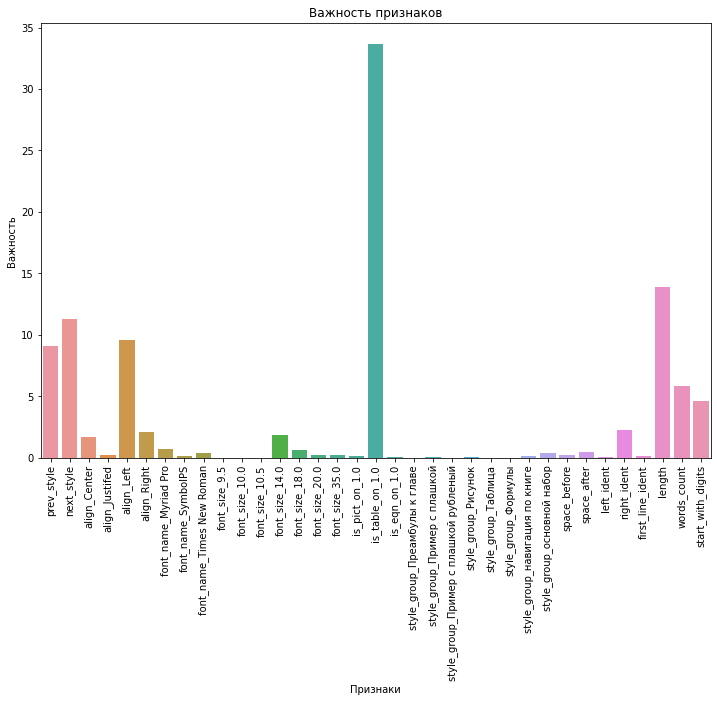

In [46]:
sns.barplot(
    x=X_test_inversed.columns,
    y=best_model_CB_enc.feature_importances_
)

plt.title('Важность признаков')
plt.xticks(rotation=90)
plt.xlabel('Признаки')
plt.ylabel('Важность')

## Проверка в боевых условиях

In [8]:
# Переопределим документ 
my_doc = app.ActiveDocument


In [9]:

# Добавим стили, если их нет
add_styles()

# Определим main_story
main_story_battletest = get_main_story()

# Разобьем на абзацы и создадим еще один датафрейм
pre_data_battletest = get_paragraphs(main_story_battletest)
data_battletest = features_engineering(pre_data_battletest)

data_battletest

Style Пример формула конец  is on!!!!
Style Пример рисунок конец  is on!!!!
Style Пример Р формула конец  is on!!!!
Style Пример Р рисунок конец  is on!!!!
Max story length: 2857 
Stories: 108 
Max story index: 4
Paragraphs in max story: 2857


,paragraph,content,align,style_group,style,prev_style,next_style,font_name,font_size,space_before,...,left_ident,right_ident,first_line_ident,is_pict_on,is_table_on,is_eqn_on,length,words_count,start_with_digits,group+style
0,<COMObject Item>,Светлой памяти наших дорогих учителей,Justifed,основной набор,Цитата,NaN,Цитата,CharterITC,9.5,0.0,...,50.0,0.0,5.0,False,False,False,37,5,0,основной набор &&& Цитата
1,<COMObject Item>,Марка Ароновича Айзермана и Льва Ильича Розоноэра,Justifed,основной набор,Цитата,Цитата,Цитата,CharterITC,9.5,0.0,...,50.0,0.0,5.0,False,False,False,49,7,0,основной набор &&& Цитата
2,<COMObject Item>,посвящается.,Justifed,основной набор,Цитата,Цитата,Приложения к книге,CharterITC,9.5,0.0,...,50.0,0.0,5.0,False,False,False,12,1,0,основной набор &&& Цитата
3,<COMObject Item>,Введение,Center,навигация по книге,Приложения к книге,Цитата,Основной текст,Myriad Pro,18.0,10.0,...,0.0,0.0,0.0,False,False,False,8,1,0,навигация по книге &&& Приложения к книге
4,<COMObject Item>,Математические модели в политических науках ис...,Justifed,основной набор,Основной текст,Приложения к книге,Основной текст,CharterITC,10.5,0.0,...,0.0,0.0,5.0,False,False,False,173,21,0,основной набор &&& Основной текст
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2852,<COMObject Item>,"223.\tWey, T. H. The algebraic foundations of ...",Justifed,основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,0.0,...,0.0,0.0,5.0,False,False,False,115,21,0,основной набор &&& Основной текст
2853,<COMObject Item>,"224.\tYap, L. The attraction of cities: A revi...",Justifed,основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,0.0,...,0.0,0.0,5.0,False,False,False,161,30,0,основной набор &&& Основной текст
2854,<COMObject Item>,"225.\tYoung, H. P. Extending Condorcet’s rule ...",Justifed,основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,0.0,...,0.0,0.0,5.0,False,False,False,129,27,0,основной набор &&& Основной текст
2855,<COMObject Item>,"226.\tYoung, H. P. Social choice scoring funct...",Justifed,основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,0.0,...,0.0,0.0,5.0,False,False,False,136,26,0,основной набор &&& Основной текст


In [10]:
real_styles = data_battletest[['style_group', 'style']]

#data_battletest = data_battletest.drop(['paragraph', 'content', 'style', 'group+style'], axis=1)

In [23]:
data_battletest_transformed = fin_pipe.transform(data_battletest.drop(['paragraph', 'content', 'style', 'group+style'], axis=1))

In [24]:
predictions = best_model_CB_enc.predict(data_battletest_transformed)
predictions = le.inverse_transform(predictions)

predictions.shape

NameError: name 'best_model_CB_enc' is not defined

In [ ]:
predict_dataframe = pd.DataFrame(predictions, columns=['group+style'])

predict_dataframe['style_group'] = predict_dataframe['group+style'].apply(lambda x: x.split(' &&& ')[0])
predict_dataframe['style'] = predict_dataframe['group+style'].apply(lambda x: x.split(' &&& ')[1])

data_battletest['group+style'].unique()

array(['основной набор &&& Цитата',
       'навигация по книге &&& Приложения к книге',
       'основной набор &&& Основной текст',
       'навигация по книге &&& Глава', 'Рисунок &&& Рисунок',
       'Рисунок &&& Подрисуночная подпись',
       'Формулы &&& Формула однострочная', 'Рисунок &&& Рисунок - текст',
       'навигация по книге &&& 1.1',
       'Пример с плашкой &&& Пример с плашкой_ Внутри',
       'Таблица &&& Табл. номер',
       '43446_1_978-5-534-18456-3.indd &&& [Без стиля]',
       'навигация по книге &&& 1.1.1.', 'Формулы &&& Формула 5 мм',
       'основной набор &&& Нулевой отступ',
       'навигация по книге &&& 1.1.1.1.'], dtype=object)

In [68]:
#real_styles['style_group'].unique()

data_battletest
#i=1

#my_doc.name
#main_story_battletest.paragraphs.Item(i+1).appliedParagraphStyle = my_doc.allparagraphStyleGroups.item(predict_dataframe['style_group'][i]).paragraphStyles.item(predict_dataframe['style'][i])

,paragraph,content,align,style_group,style,prev_style,next_style,font_name,font_size,space_before,...,left_ident,right_ident,first_line_ident,is_pict_on,is_table_on,is_eqn_on,length,words_count,start_with_digits,group+style
0,<COMObject Item>,Светлой памяти наших дорогих учителей,Justifed,основной набор,Цитата,NaN,Цитата,CharterITC,9.5,0.0,...,50.0,0.0,5.0,False,False,False,37,5,0,основной набор &&& Цитата
1,<COMObject Item>,Марка Ароновича Айзермана и Льва Ильича Розоноэра,Justifed,основной набор,Цитата,Цитата,Цитата,CharterITC,9.5,0.0,...,50.0,0.0,5.0,False,False,False,49,7,0,основной набор &&& Цитата
2,<COMObject Item>,посвящается.,Justifed,основной набор,Цитата,Цитата,Приложения к книге,CharterITC,9.5,0.0,...,50.0,0.0,5.0,False,False,False,12,1,0,основной набор &&& Цитата
3,<COMObject Item>,Введение,Center,навигация по книге,Приложения к книге,Цитата,Основной текст,Myriad Pro,18.0,10.0,...,0.0,0.0,0.0,False,False,False,8,1,0,навигация по книге &&& Приложения к книге
4,<COMObject Item>,Математические модели в политических науках ис...,Justifed,основной набор,Основной текст,Приложения к книге,Основной текст,CharterITC,10.5,0.0,...,0.0,0.0,5.0,False,False,False,173,21,0,основной набор &&& Основной текст
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2852,<COMObject Item>,"223.\tWey, T. H. The algebraic foundations of ...",Justifed,основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,0.0,...,0.0,0.0,5.0,False,False,False,115,21,0,основной набор &&& Основной текст
2853,<COMObject Item>,"224.\tYap, L. The attraction of cities: A revi...",Justifed,основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,0.0,...,0.0,0.0,5.0,False,False,False,161,30,0,основной набор &&& Основной текст
2854,<COMObject Item>,"225.\tYoung, H. P. Extending Condorcet’s rule ...",Justifed,основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,0.0,...,0.0,0.0,5.0,False,False,False,129,27,0,основной набор &&& Основной текст
2855,<COMObject Item>,"226.\tYoung, H. P. Social choice scoring funct...",Justifed,основной набор,Основной текст,Основной текст,Основной текст,CharterITC,10.5,0.0,...,0.0,0.0,5.0,False,False,False,136,26,0,основной набор &&& Основной текст


In [69]:
for i in range(0, main_story_battletest.Paragraphs.Count):
    if (real_styles['style'][i] != predict_dataframe['style'][i]) & (real_styles['style_group'][i] != predict_dataframe['style_group'][i]):
        # print('Real:   ', real_styles['style_group'][i], real_styles['style'][i], '\n')
        # print('Predict:', predict_dataframe['style_group'][i], predict_dataframe['style'][i], '\n')
        # print('-'*20)

        if predict_dataframe['style_group'][i] == 'основной набор':
            main_story_battletest.paragraphs.Item(i+1).appliedParagraphStyle = my_doc.paragraphStyleGroups.item(predict_dataframe['style_group'][i]).paragraphStyles.item(predict_dataframe['style'][i])
            print('Paragraph', i, 'added style', predict_dataframe['style'][i], 'from', predict_dataframe['style_group'][i])
        elif predict_dataframe['style_group'][i] in [
                                                    'Рисунок',
                                                    'Формулы',
                                                    'Пример с плашкой',
                                                    'Пример с плашкой рубленый',
                                                    'Преамбулы к главе',
                                                    'Петиты',
                                                    'Код',
                                                    'Таблица'
                                                    ]:
            main_story_battletest.paragraphs.Item(i+1).appliedParagraphStyle = my_doc.paragraphStyleGroups.item('основной набор').paragraphStyleGroups.item(predict_dataframe['style_group'][i]).paragraphStyles.item(predict_dataframe['style'][i])
            print('Paragraph', i, 'added style', predict_dataframe['style'][i], 'from', predict_dataframe['style_group'][i])
        else:
            main_story_battletest.paragraphs.Item(i+1).appliedParagraphStyle = my_doc.paragraphStyleGroups.item(predict_dataframe['style_group'][i]).paragraphStyles.item(predict_dataframe['style'][i])
            print('Paragraph', i, 'added style', predict_dataframe['style'][i], 'from', predict_dataframe['style_group'][i])


        # main_story_battletest.paragraphs.Item(i+1).appliedParagraphStyle = my_doc_battletest.allParagraphStyles[styles[predictions[i]]]
        # main_story_battletest.paragraphs.Item(i+1).fillColor = my_color


# my_doc.paragraphStyleGroups.item('основной набор').paragraphStyleGroups.item('Пример с плашкой').paragraphStyles.item('Пример формула конец')

# Покрасить параграфы с изменением стиля!
# Менять только измененные стили!

Paragraph 60 added style Рисунок from Рисунок
Paragraph 67 added style Рисунок from Рисунок
Paragraph 72 added style Рисунок from Рисунок
Paragraph 75 added style Рисунок from Рисунок
Paragraph 79 added style Рисунок from Рисунок
Paragraph 83 added style Рисунок from Рисунок
Paragraph 87 added style Рисунок from Рисунок
Paragraph 144 added style Рисунок from Рисунок
Paragraph 158 added style Петит Внутри from Петиты
Paragraph 165 added style Рисунок from Рисунок
Paragraph 181 added style Рисунок from Рисунок
Paragraph 193 added style Рисунок from Рисунок
Paragraph 197 added style Рисунок from Рисунок
Paragraph 214 added style Рисунок from Рисунок
Paragraph 253 added style Рисунок from Рисунок
Paragraph 257 added style Рисунок from Рисунок
Paragraph 261 added style Рисунок from Рисунок
Paragraph 269 added style Рисунок from Рисунок
Paragraph 276 added style Рисунок from Рисунок
Paragraph 286 added style Рисунок from Рисунок
Paragraph 299 added style Рисунок from Рисунок
Paragraph 307 ad

In [8]:
#main_story_battletest.paragraphs.Item(1).fillColor.colorValue=[250,0,0]

try:
    new_color = my_doc.colors.add()
    print('New color', new_color,'added!')

    #new_color.colorValue = [255, 10, 255]
    my_doc.Swatches(new_color).colorValue = [250, 0, 0]
except:
    print('Cant add color', new_color)

rect = main_story_battletest.paragraphs.Item(1)
rect.fillColor = my_doc.Swatches(new_color)


New color Черный (копия) 2 added!
Cant add color Черный (копия) 2


NameError: name 'main_story_battletest' is not defined

In [71]:
#new_color = my_doc_battletest.Swatches.add()

#my_doc_battletest.Swatches(new_color).name = 'Changes'

main_story_battletest.paragraphs.Item(1).fillColor = 'Blue'
#my_doc_battletest.Swatches(new_color)

In [77]:
res = pd.DataFrame({'real': real_styles['style'], 'predictions': predict_dataframe['style']},)

res.query('real != predictions')

#res

,real,predictions
50,Рисунок - текст,Подрисуночная подпись
60,[Без стиля],Рисунок
67,[Без стиля],Рисунок
72,[Без стиля],Рисунок
75,[Без стиля],Рисунок
...,...,...
2588,[Без стиля],Рисунок
2597,[Без стиля],Рисунок
2604,[Без стиля],Рисунок
2607,[Без стиля],Рисунок
